# Working with images in python

## array to image to file

Create an image as a set of rgb values in an numpy array, convert it to pil image and write a png. First explore 
the image arrary data structure. To do that we read an image into an PIL image and then convert it to an ndarray. Then we can explore the data layout. Later we build an array and convert it to an image with PIL. Then display that image to see if the pixels end up where we think they will. 


In [1]:
#import stuff and read the image
import numpy as np
from PIL import Image, ImageOps
import os
import matplotlib.pyplot as plt
%matplotlib inline
imagefile = os.path.join(os.path.expanduser("~"),"Documents/TeXRay\Images\sparrowhawk.jpg")
im = Image.open(imagefile)

In [2]:
type(im)
imarray = np.array(im)
imarray.shape

(1421, 1911, 3)

The dimensions of our image array are shown above. It looks like the standard "C" ordering has the pixel rgb values stored as an array of triples by row. The first pixel is:

In [3]:
imarray[0,0]

array([109,  94,  65], dtype=uint8)

The first three pixels in the top row are:

In [4]:
imarray[0,0:3]

array([[109,  94,  65],
       [108,  93,  64],
       [108,  93,  64]], dtype=uint8)

Build an array and morph it into an image. This bit of code builds a 200 by 100 (wxh) image by creating an array of integers 0 < x < 255. It does that by scaling the r,g, and b values linearly with the width and height of the image. Red is scaled from left to right, green is scaled from top to bottom and blue is constant at 0.2 times 255. In order to insure the scaling is correct the calculations are done in floating point and then converted to int by chopping off the remainder. Thus value = float(i)/float(nx)X255.9; 0 <= i <= nx gives i/nx between 0 and 1.0. This leads to 0 <= value <= 255.9. Which gives the correct integer value. Note that the array must be dtype = np.uint8. Using np.int8 is wrong because it is a signed value that goes from -127 - 127.

we need to take care of how the image data is set up. The data is loaded in "C" order or by rows rather than columns. This means for an image that has a width of nx and height of ny we have to create a numpy array with the shape (height,width,colors). This means the rgb values will be contiguous in memory. pixels will be contiguous in the nx direction followed by ny. See the code below for loading index math. Also note that for the image data the zeroth row of the data is displayed at the top of the image. Graphics convention is the origin of the image is at the bottom left corner of the data. This has to be corrected for when loading the array to ensure the image isnt upside down. this could be accomplished when traversing and loading the array or one could use an image transform after the fact.  Again see below for the first method.

In [5]:
nx=200
ny=100
testimagearray = np.zeros((ny,nx,3),dtype=np.uint8)
b = int(255.9*0.0)
maxj = np.arange(ny)[-1]
for j in np.arange(ny):
    g = int(255.9*float(maxj - j)/float(ny)) #flip the y axis. 
    for i in np.arange(nx):
        r = int(255.9*float(i)/float(nx))
        testimagearray[j,i] = [r,g,b]

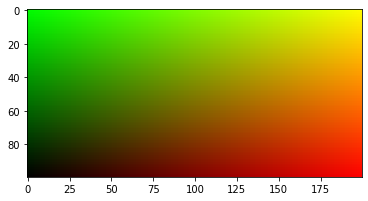

In [6]:
#explore the array
newimage = Image.fromarray(testimagearray)
plt.imshow(newimage)

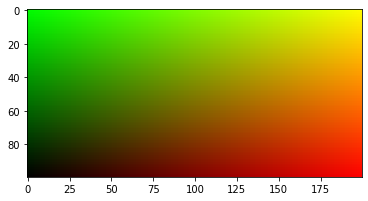

In [7]:
#lets make another test image and flip it using pil rather than programatically
#we should get the same image. 
testimagearray2 = np.zeros((ny,nx,3),dtype=np.uint8)
b = int(255.9*0.0)
for j in np.arange(ny):
    g = int(255.9*float( j)/float(ny))  
    for i in np.arange(nx):
        r = int(255.9*float(i)/float(nx))
        testimagearray2[j,i] = [r,g,b]
# now flip and display
newimage2 = Image.fromarray(testimagearray2)
plt.imshow(ImageOps.flip(newimage2))

Now we want to save the image to a file. Again using pil module. 

In [8]:
# save the first newimage
newimage.save("..\Images\colorblah.png","PNG")

## Image Pixel order. 

We see that the image pixel order in PIL is from top left corner to bottom right. That is pixel rows are counted from top to bottom starting with row 0 and going down to row ny-1. The ordering of columns is from left to right starting with column 0 and ending with column nx-1. The memory storage order is 'C' row major order. Pixels are stored by rows starting from the left edge and running to the right edge row by row. The row major storage order has the column index changing fastest. The pixel in row 'p' and column 'q' of a PIL image is indexed as pixel[q,p] The index on the right (row index) changes fastest in C ordering. Numpy arrays use C row major by default. 

In [9]:
# Get the values of the pixel in the top left corner of the PIL newimage
# the top left should be all green.
print(f'r,g,b {np.array(newimage)[0,0]} {newimage.getpixel((0,0))}')
# the bottim right should be all red
print(f'r,g,b {np.array(newimage)[ny-1,nx-1]} {newimage.getpixel((nx-1,ny-1))}')

r,g,b [  0 253   0] (0, 253, 0)
r,g,b [254   0   0] (254, 0, 0)


The PIL image object itself cant be indexed but it provides a getpixel method that takes a tuple as an index. The indexing order appears to be reversed from that of the underlying numpy array. That is the x index is first and the y index is second in the PIL.image object. The indexing still goes from top left to bottom right. 

All of this is a bit much to keep straight in our heads. We want an image that counts from bottom left to top right. Let the i index range from 0 to nx-1 in the x (horizontal) direction and the j index range from 0 to ny-1 in the y or vertical direction. With i=0,j=0 in the bottom left and i=nx-1 j=ny-1 in the top right corner. Then we want to be able to index the image as ImageObject[i,j] and get the right pixel. ie the one i pixels to the right of the left edge and j pixels up from the bottom edge. In order to accomplish this we create our own image class as a wrapper around the PIL library that indexes things as we like.   

## new image class
The class below is a new image class that wraps a numpy array in such a way that indexing of the array starts at the bottom left corner. This is how image data is typically indexed. That is sequentially from the bottom left corner from left to right. 

The image data consists of a numpy array of dimensions (height,width,3). This results in the data being layed out along rows of the array. In 'C' order. In this arrangement the pixel data RGB values are adjascent. The image data are stored in the numpy array such that the pixels that make up the bottom row of the image (image row 0) are stored in the last row of the numpy array (array row height -1). 

Displaying the contents of numpy arrays with PIL indexes the data from top to bottom and left to right. By modifying the index of the data as it is loaded into the array such that the row index is reversed we can stor the image right side up. 

This also makes it easier to think about the image class representing an atual image indexed from the lower left corner when setting pixel data. 

In [10]:
import numpy as np
class image:
    """
    A numpy based image container. The image resides in a numpy array

    
    """
    def __init__(self,height=100,width=200):
        self._width = width
        self._height = height
        self._data = np.zeros((height,width,3),dtype=np.uint8)
# fix the indexing so the input y index is reversed
# this insures the origin of the image is at the bottom left 
# index wise. 
    def __getitem__(self,key):
        return self._data[key]
    def __setitem__(self,key,value):
        newkey = self._reverse_height_index(key)
        self._data[newkey] = value
    @property
    def width(self):
        return self._width
    @property
    def height(self):
        return self._height
    def _reverse_height_index(self,key):
        """ internal method to adjust the row index to count from
        the bottom of the array instead of the top. This insures the
        image is indexed from the bottom left corner. 
        """
        # this reverses the height index value
        if isinstance(key,int):  # got a single index. 
            newkey = self._height - key -1 
        elif isinstance(key,tuple): # we have multiple indices
            keylist = list(key) # create a mutable object
            if isinstance(keylist[0],int): 
                # first element is int
                keylist[0] = self._height - key[0] -1
                newkey = tuple(keylist)
            elif isinstance(keylist[0],slice): 
                # first element is slice
                if keylist[0].start is None:
                    start = self._height -1
                else:
                    start = self._height - 1 - key[0].start 
                if keylist[0].stop is None:
                    stop = None
                else:
                    stop = self._height-key[0].stop -1
                if key[0].step is None:
                    step = -1
                else:
                    step = -key[0].step
                keylist[0] = slice(start,stop,step)
                newkey = tuple(keylist)
        return newkey

Now lets test this class. Creat an empth image. The default height is 100 and the default width is 200. Lets load up the image with something that we expect and see if we are correct. Lets render the italian flag. The flag is equal parts green, white, and red going left to right. Green pixels have values (0,255,0) and red pixels have value (255,0,0). Finally white pixels are (255,255,255).

In [11]:
# test image class by making a flag
tricolore = image()
red = (255,0,0)
white = (255,255,255)
green = (0,255,0)
width = tricolore.width
height = tricolore.height
# load up the flag
for row in range(height):
    for col in range(width):
        if col < width/3:
            tricolore[row,col] = green
        elif col < 2*width/3:
            tricolore[row,col] = white
        else:
            tricolore[row,col] = red

Now lets see if we have what we expect to have. 

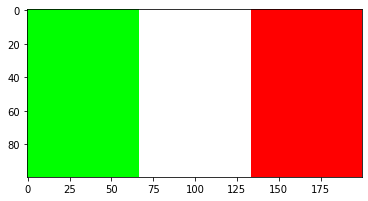

In [12]:
from PIL import Image
import matplotlib.pyplot as plt 
%matplotlib inline
#newimage = Image.fromarray(testimagearray)
plt.imshow(Image.fromarray(tricolore[:,:]))

This looks right. Green on the left and red on the right. So the column indexing is right. Now lets test the row indexing. Hang the flag on the wall with green on top and red on the bottom. Allocate a new image with height 200 and width 100 and load it with colors green to red row wise this time. 


In [13]:
tricolore2 = image(height=20,width=10)
width = tricolore2.width
height = tricolore2.height
# load up the flag. Note how the image is loaded. We start loading
# pixels at the bottom left corner. This should be red since the
# flag will hang gree stripe up. Image order is from bottom to top.
for row in range(height):
    for col in range(width):
        if row < height/3:
            tricolore2[row,col] = red
        elif row < 2*height/3:
            tricolore2[row,col] = white
        else:
            tricolore2[row,col] = green

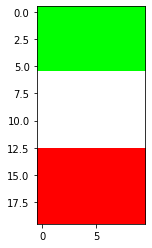

In [14]:
plt.imshow(Image.fromarray(tricolore2[:,:]))

ok that's what we expected. Im gonna call it. The image class seems to be doing the right thing. The prototype of the image class is done. 